In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.rcParams["figure.figsize"] = (10, 10)

To be cleaned up!

# Monotonic transformation of a random variable

In [114]:
# X ~ N(0, 1)
X = st.norm()

# y = g(x) = 3 * x + 1
g = lambda x: 3 * x + 1

# f_Y(y) = |d/dy g_inv(y)| * f_X(g_inv(y))
import theano
import theano.tensor as T

y_i = T.dscalar("y_i")
_g_inv = y_i / 3 - 1 / 3
g_inv = theano.function([y_i], _g_inv)
_J = T.abs_(T.grad(_g_inv, y_i))
J = theano.function([y_i], _J)

f_Y = np.vectorize(lambda y_i: J(y_i) * X.pdf(g_inv(y_i)))

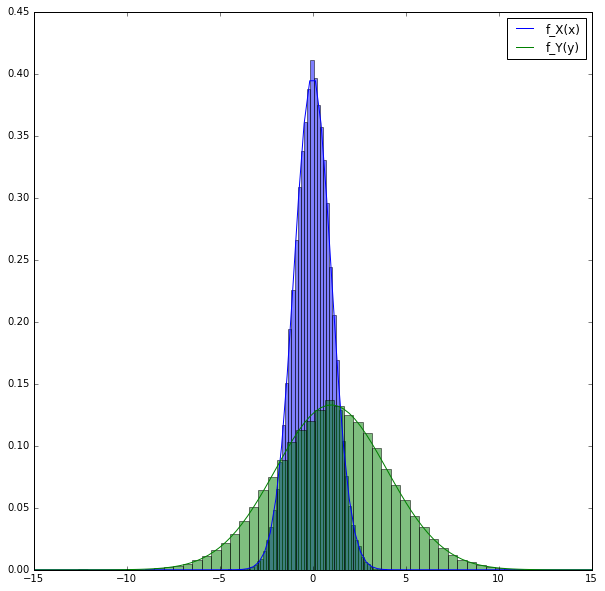

In [115]:
reals = np.linspace(-15, 15, num=100)
samples = X.rvs(50000)

plt.hist(samples, normed=1, bins=50, alpha=0.5, color="b")
plt.plot(reals, X.pdf(reals), label="f_X(x)", color="b")

plt.hist(g(samples), normed=1, bins=50, alpha=0.5, color="g")
plt.plot(reals, f_Y(reals), label="f_Y(y)", color="g")

plt.legend()
plt.show()

# Transformation in 2D

In [212]:
# X ~ N(0, 1)
X = st.multivariate_normal(mean=[0, 0], cov=2*np.eye(2)) #cov=[[1, 0], [1, 3]])

# y = g(x) 
# theta = -np.pi / 4
# g = lambda x_i: np.dot(np.array([[np.cos(theta), -np.sin(theta)], 
#                                  [np.sin(theta), np.cos(theta)]]), 
#                        x_i)

x_i = T.dvector("x_i")
r = T.sqrt(x_i[0] ** 2 + x_i[1] ** 2)
phi = T.arctan2(x_i[1], x_i[0])
_g = T.stack(r, phi)
g = theano.function([x_i], _g)

# f_Y(y) = ...
import theano
import theano.tensor as T
from theano.sandbox.linalg import det

y_i = T.dvector("y_i")
_x = y_i[0] * T.cos(y_i[1])
_y = y_i[0] * T.sin(y_i[1])
_g_inv = T.stack(_x, _y)
g_inv = theano.function([y_i], _g_inv)

# y_i = T.dvector("y_i")

# rotation = T.dmatrix()
# inv_default = np.array([[np.cos(-theta), -np.sin(-theta)],
#                         [np.sin(-theta), np.cos(-theta)]])
# _g_inv = T.dot(rotation, y_i)
# g_inv = theano.function([y_i, theano.Param(rotation, default=inv_default)], _g_inv)

_J = T.abs_(det(T.jacobian(_g_inv, y_i)))
#_J = T.abs_(y_i[0])
J = theano.function([y_i], _J)

def f_Y(Y):
    r = []
    
    for y_i in Y:
        # For sure, there is a better way than explicitely computing det(J)
        r.append(J(y_i) * X.pdf(g_inv(y_i)))
        
    return np.array(r)

[]

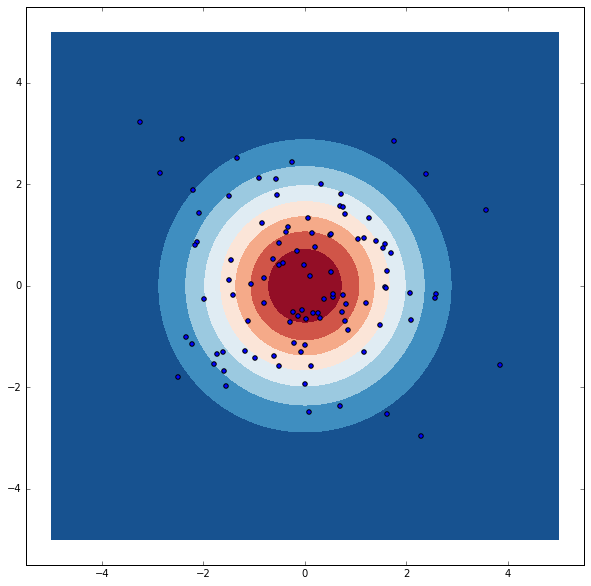

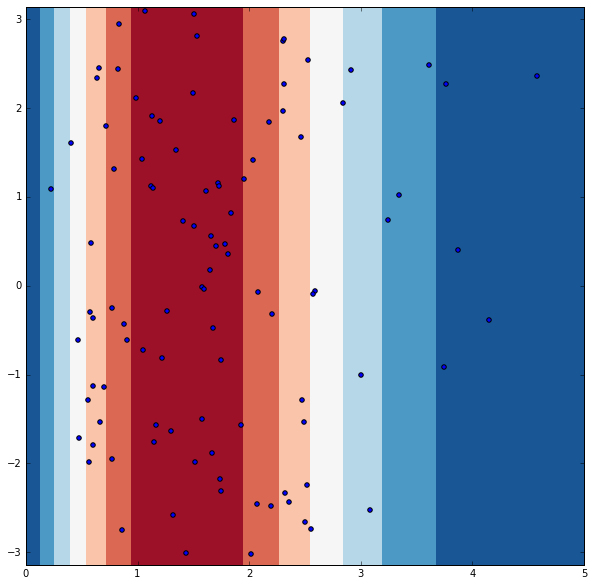

In [211]:
samples = X.rvs(100)

xx, yy = np.meshgrid(np.linspace(-5, 5, 200), 
                     np.linspace(-5, 5, 200))
zz = np.c_[xx.ravel(), yy.ravel()]

plt.figure()
plt.contourf(xx, yy, X.pdf(zz).reshape(xx.shape), cmap=plt.cm.RdBu_r)
plt.scatter(samples[:, 0], samples[:, 1])
plt.plot()

plt.figure()
plt.contourf(xx, yy, f_Y(zz).reshape(xx.shape), cmap=plt.cm.RdBu_r)
samples = np.array([g(x_i) for x_i in samples])
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlim(0, 5)
plt.ylim(-np.pi, np.pi)
plt.plot()

# see http://kaharris.org/teaching/425/Lectures/lec30.pdf

# What if non-monotonic transformation?